**Objetivos:** 
- Implementar los modelos vistos en clase tanŧo de regresión como de claificación sobre el data set de galaxias 
- Realizar un análisis de los resultados obtenidos que cada una de las pruebas
- Comparar la performance y seleccionar el mejor modelo tanto para tabla como para imágenes

# Paquetes necesarios 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

,ra,dec,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,petroR90_r,Color,elliptical,spiral,uncertain,distancia_L,Mag_abs
objID,,,,,,,,,,,,,,
1.237674e+18,119.822479,42.008528,17.36539,15.46586,14.54658,14.07490,13.69937,18.121160,-2.818807,1.0,0.0,0.0,135.131916,-21.191136
1.237674e+18,118.185239,33.699089,19.95136,18.35397,17.54043,17.05026,16.71222,3.657189,-2.410933,0.0,0.0,1.0,153.893111,-18.473102


(32623, 14)

'distribución de las variables físicas de las galaxias'

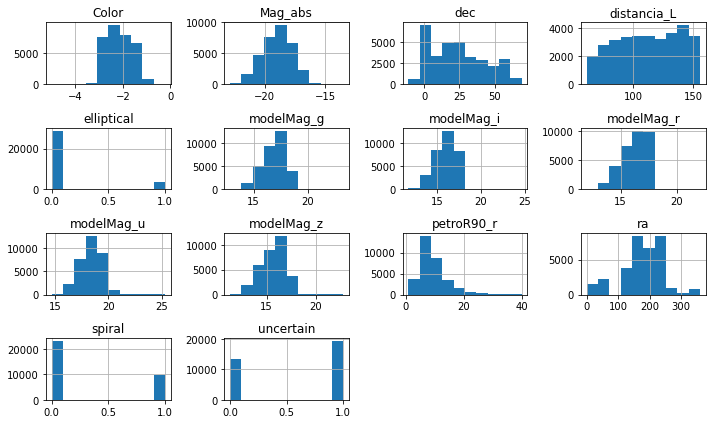

In [3]:
dataset = pd.read_csv('galaxias_2.csv', index_col=['objID'])
display(dataset.head(2))
display(dataset.shape)
display('distribución de las variables físicas de las galaxias')
dataset.hist()
plt.tight_layout()

# Analisis de Datos

In [4]:
dataset.columns

Index(['ra', 'dec', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroR90_r', 'Color', 'elliptical', 'spiral',
       'uncertain', 'distancia_L', 'Mag_abs'],
      dtype='object')

In [5]:
data_cl = dataset.loc[~(dataset.index.astype(str).duplicated(keep="first"))]
data_cl.shape

(18007, 14)

In [6]:
def galaxy_type(row):
    if row["elliptical"]:
        return "E"
    elif row["spiral"]:
        return "S"
    else:
        return "I"

In [7]:
data_cl["Type"] = data_cl.apply(galaxy_type, axis=1)

<ipython-input-7-ac09d0ce4d89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cl["Type"] = data_cl.apply(galaxy_type, axis=1)


/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


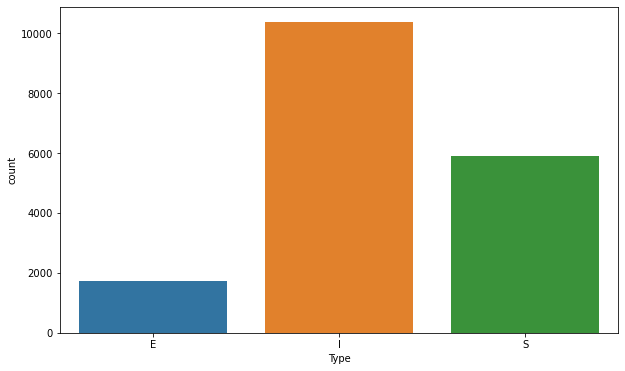

In [8]:
sns.countplot(data_cl["Type"])

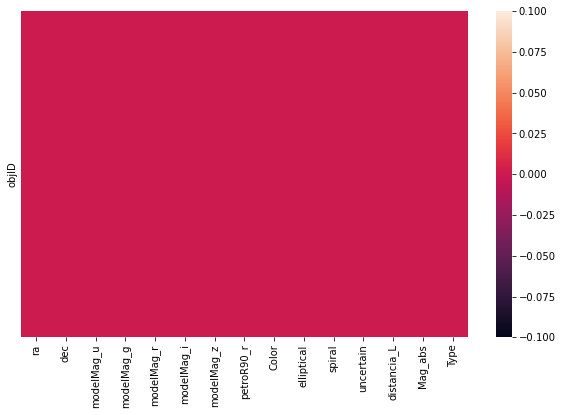

In [9]:
sns.heatmap(data_cl.isna(), yticklabels=False)

In [10]:
def distribution_per_type(df, col_name="", bins=20):
    plt.title(f"{col_name.capitalize()} Distribution")
    sns.distplot(df[df["elliptical"] == 1][col_name],label="elliptical", bins=bins)
    sns.distplot(df[df["spiral"] == 1][col_name],label="spiral", bins=bins)
    sns.distplot(df[df["uncertain"] == 1][col_name],label="irregular", bins=bins)
    plt.legend()
    
def exploratory_plots(df, col_name=""):
    plt.subplot(3, 1, 1)
    distribution_per_type(df, col_name)
    plt.subplot(3, 1, 2)
    plt.title(f"{col_name.capitalize()} Boxplot")
    sns.boxplot(x="Type", y=col_name, data=df)

    plt.subplot(3, 1, 3)
    plt.title(f"{col_name.capitalize()} Boxplot w/o Outliers")
    sns.boxplot(x="Type", y=col_name, data=df, showfliers=False)
    
    plt.tight_layout()

## Pair Plot

In [11]:
data_cl.columns

Index(['ra', 'dec', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroR90_r', 'Color', 'elliptical', 'spiral',
       'uncertain', 'distancia_L', 'Mag_abs', 'Type'],
      dtype='object')

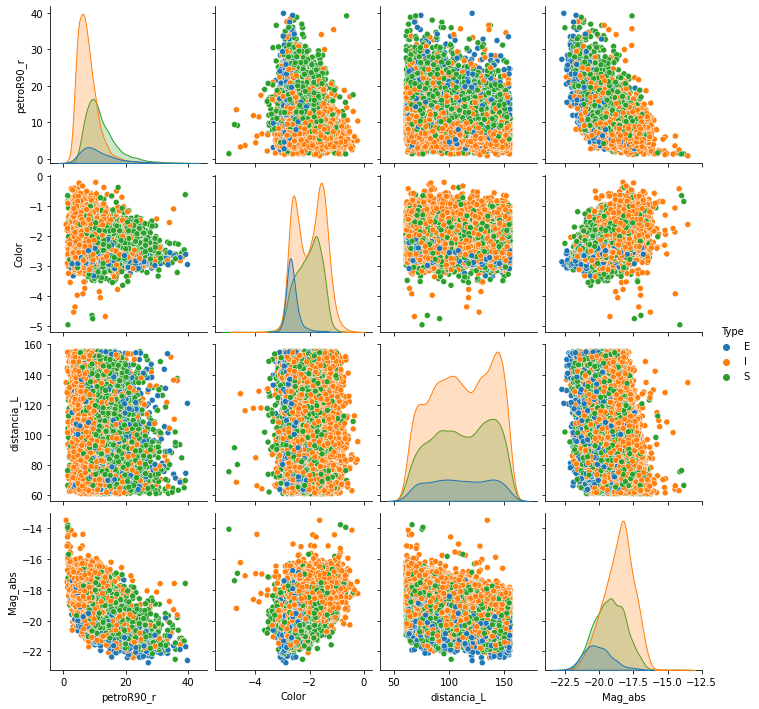

In [12]:
plot_cols = ['petroR90_r', 'Color', 'distancia_L', 'Mag_abs', 'Type']
sns.pairplot(data_cl[plot_cols], hue="Type")

## Color

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

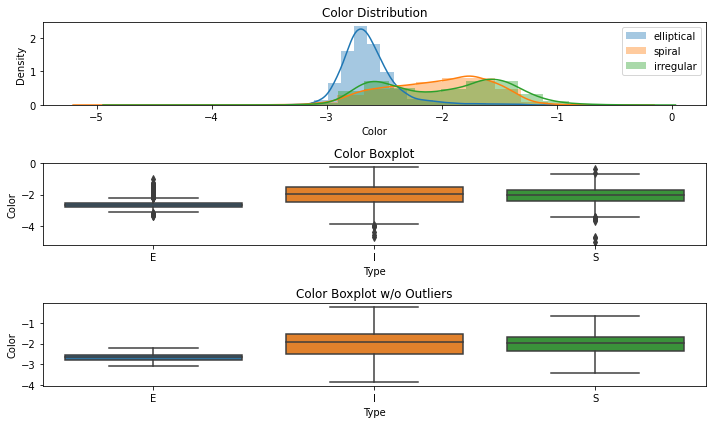

In [13]:
exploratory_plots(data_cl, "Color")

## PetroR90

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

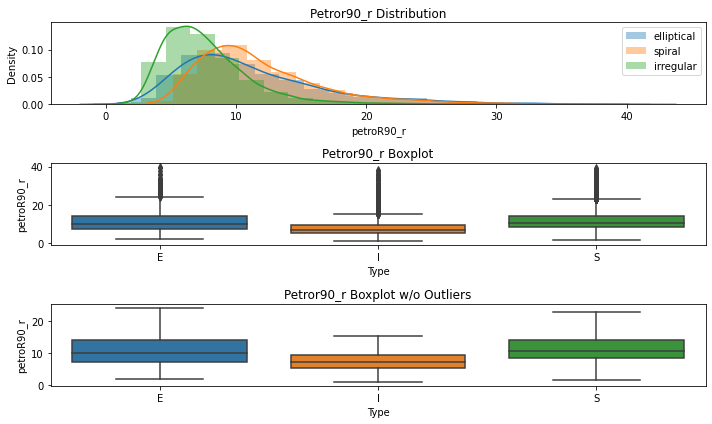

In [14]:
exploratory_plots(data_cl, "petroR90_r")

## Distancia L

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

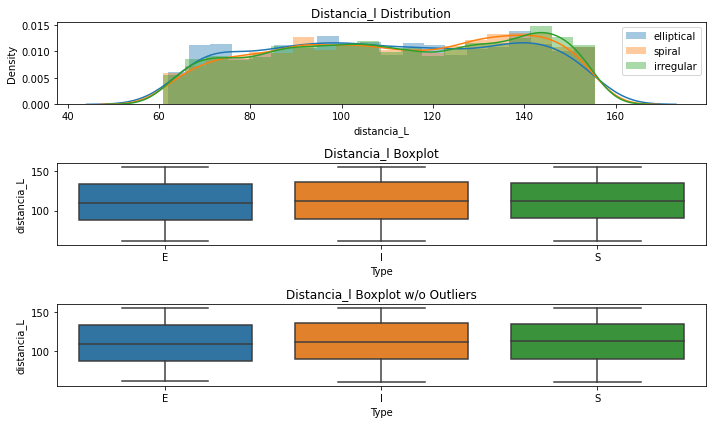

In [15]:
exploratory_plots(data_cl, "distancia_L")

## Mag_abs

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

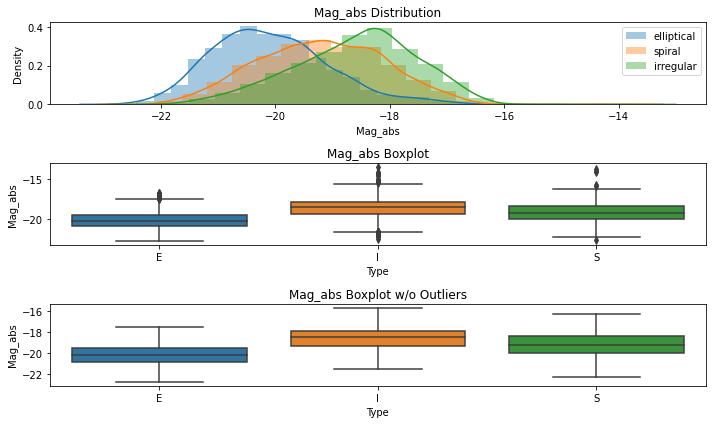

In [16]:
exploratory_plots(data_cl, "Mag_abs")

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

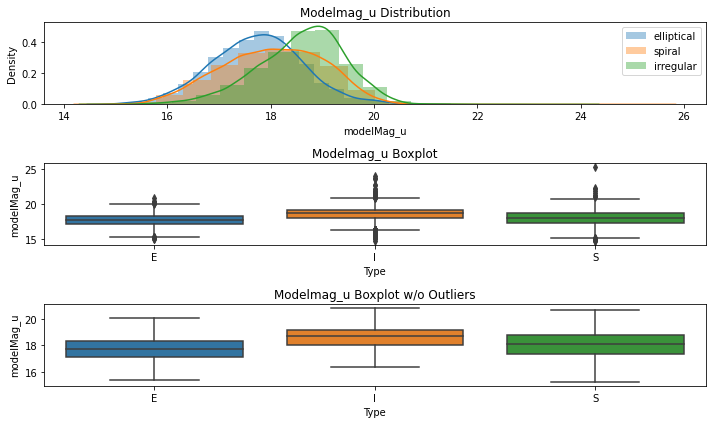

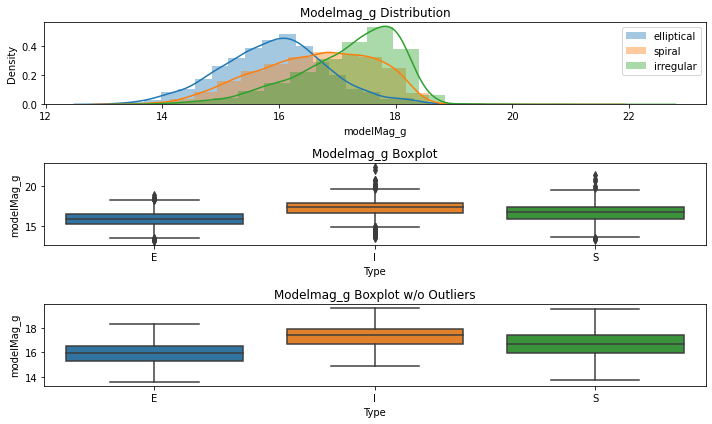

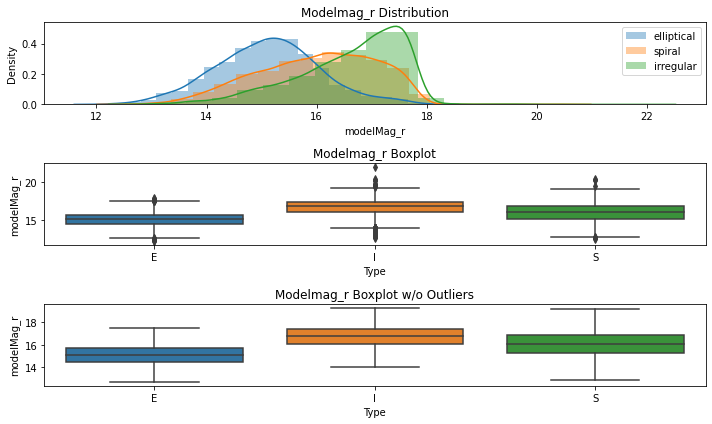

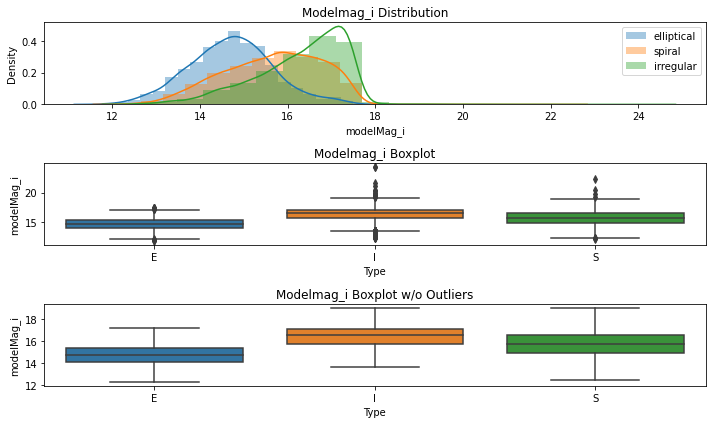

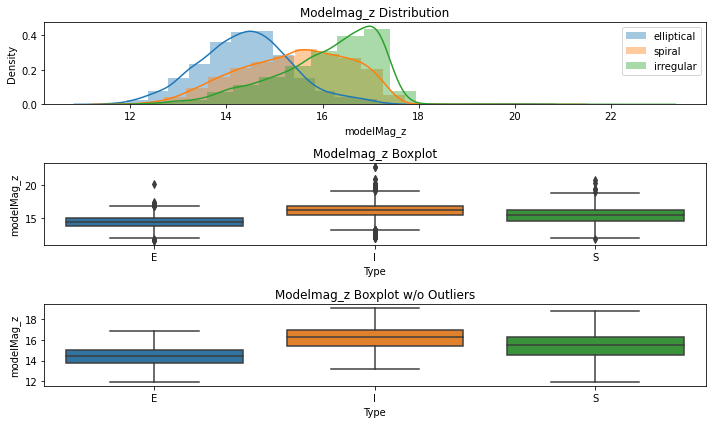

In [17]:
for mag in ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']:
    plt.figure()
    exploratory_plots(data_cl, mag)

# Regresión 


Existe una relación empírica entre el radio efectivo (petro petroR90_r) y la magnitud absoluta para galaxias  (datos de Bender et al. 1992, ApJ., 399, 462)

Por lo tanto, el valor a predecir sera  **Mag_abs** la cual está contenida en un intervalo real de tamaño ~ 9mag, el atributo a usar sera el logaritmo en base diez de la variable **petroR90_r**.

Detallar los pasos realizados (split, fit, metrica..) en el uso de el algoritmo de Regresión lineal con y sin regularización.

Responda:
- Que significa el error cuadrático?
- Que unidades tiene?
- Es necesaria la regularización?
- Es bueno valor obtenido en la métrica?
- Que pasa si se distingue por tipo de galaxia?

In [18]:
data_cl["log_petroR90"] = np.log10(data_cl["petroR90_r"])

<ipython-input-18-e25ec6afbfa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cl["log_petroR90"] = np.log10(data_cl["petroR90_r"])


/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


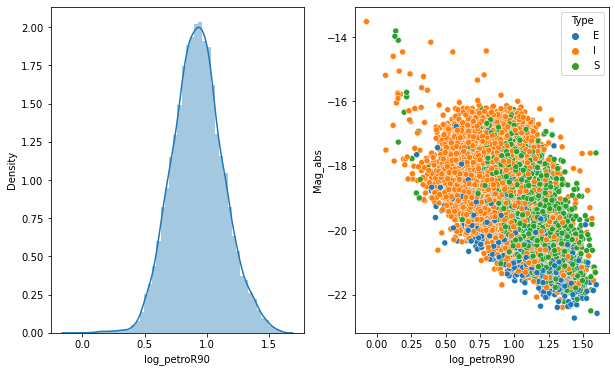

In [19]:
f, axs = plt.subplots(1,2)
sns.distplot(data_cl["log_petroR90"], ax=axs[0])
sns.scatterplot(x="log_petroR90", y="Mag_abs", data=data_cl,hue="Type", ax=axs[1])

## Train / Validation / Test Split

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, f1_score

In [21]:
X = data_cl["log_petroR90"]
y = data_cl["Mag_abs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42421)
X_train, X_test = X_train.values.reshape(-1,1), X_test.values.reshape(-1,1)

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


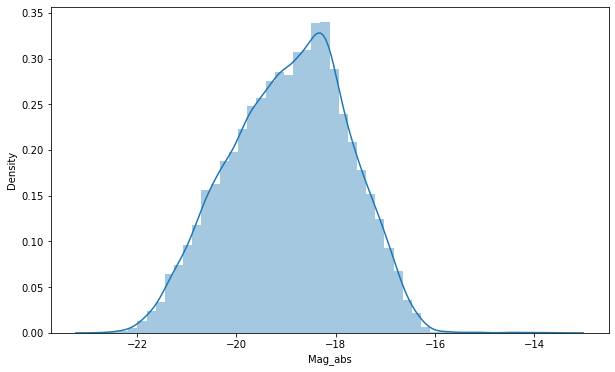

In [22]:
sns.distplot(y)

In [23]:
y.describe()

count    18007.000000
mean       -18.937537
std          1.184483
min        -22.730648
25%        -19.785564
50%        -18.858549
75%        -18.082197
max        -13.516647
Name: Mag_abs, dtype: float64

## Modelo Lineal y Regularización

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

model_lasso = Lasso(alpha=0.01, random_state=4212)
model_lasso.fit(X_train, y_train)
#list(zip(X.columns, model.coef_))

Lasso(alpha=0.01, random_state=4212)

In [25]:
y_pred = model.predict(X_test)
y_pred_lasso = model_lasso.predict(X_test)

In [26]:
print("-"*80)
print("Linear Regression")
print("R2 Score: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("SE:  ", mean_squared_error(y_test, y_pred) * y_test.shape[0])
print("-"*80)
print("Linear Regression with Lasso Regularization")
print("R2 Score: ", r2_score(y_test, y_pred_lasso))
print("MSE: ", mean_squared_error(y_test, y_pred_lasso))
print("SE:  ", mean_squared_error(y_test, y_pred_lasso) * y_test.shape[0])

--------------------------------------------------------------------------------
Linear Regression
R2 Score:  0.2789919970010071
MSE:  1.0034302380303863
SE:   3614.3557173854515
--------------------------------------------------------------------------------
Linear Regression with Lasso Regularization
R2 Score:  0.2761224678661435
MSE:  1.0074237752600075
SE:   3628.7404384865467


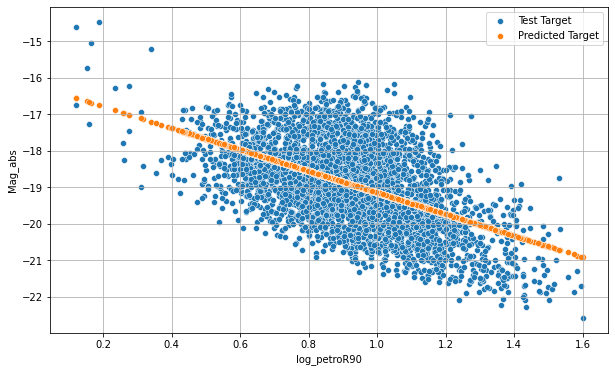

In [27]:
sns.scatterplot(x=X_test.reshape(1,-1)[0], y=y_test, label="Test Target")
sns.scatterplot(x=X_test.reshape(1,-1)[0], y=y_pred, label="Predicted Target")
plt.xlabel("log_petroR90")
plt.legend()
plt.grid()

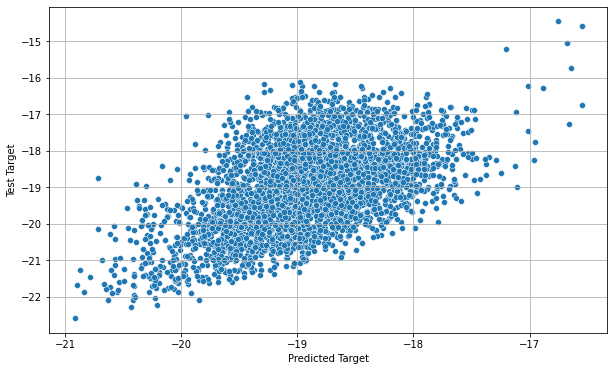

In [28]:
sns.scatterplot(x=y_pred, y=y_test)
plt.xlabel("Predicted Target")
plt.ylabel("Test Target")
plt.grid()

## Modelo por tipo de galaxia

In [29]:
X_d, y_d = {}, {}
X_train_d, X_test_d, y_train_d, y_test_d = {}, {}, {}, {}

for ttype in data_cl["Type"].unique():
    mask = data_cl["Type"] == ttype
    X_d[ttype] = data_cl[mask]["log_petroR90"]
    y_d[ttype] = data_cl[mask]["Mag_abs"]

    X_train_d[ttype], X_test_d[ttype], y_train_d[ttype], y_test_d[ttype] = \
    train_test_split(X_d[ttype], y_d[ttype], test_size=0.2, random_state=42421)
    X_train_d[ttype], X_test_d[ttype] = X_train_d[ttype].values.reshape(-1,1), X_test_d[ttype].values.reshape(-1,1)

In [30]:
models = {}
y_pred_train_d = {}
y_pred_test_d  = {}
for ttype in data_cl["Type"].unique():
    models[ttype] = LinearRegression()
    models[ttype].fit(X_train_d[ttype], y_train_d[ttype])
    y_pred_train_d[ttype] = models[ttype].predict(X_train_d[ttype])
    y_pred_test_d[ttype] = models[ttype].predict(X_test_d[ttype])

for ttype in data_cl["Type"].unique():
    print("-"*80)
    print(ttype)
    print("-"*80)
    print("R2 Score: ", r2_score(y_test_d[ttype], y_pred_test_d[ttype]))
    print("MSE: ", mean_squared_error(y_test_d[ttype], y_pred_test_d[ttype]))
    print(models[ttype].coef_)

--------------------------------------------------------------------------------
E
--------------------------------------------------------------------------------
R2 Score:  0.4452439100100506
MSE:  0.6325553505792613
[-3.32708517]
--------------------------------------------------------------------------------
I
--------------------------------------------------------------------------------
R2 Score:  0.14991644057874098
MSE:  1.038591271711517
[-2.08425229]
--------------------------------------------------------------------------------
S
--------------------------------------------------------------------------------
R2 Score:  0.2861847012598092
MSE:  0.8544626670983083
[-3.5546626]


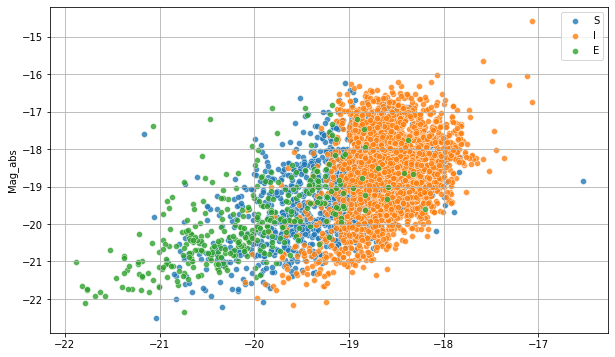

In [31]:
for ttype in data_cl["Type"].unique()[::-1]:
    sns.scatterplot(x=y_pred_test_d[ttype], y=y_test_d[ttype], alpha=0.8, label=ttype)
    plt.grid()
    plt.legend()

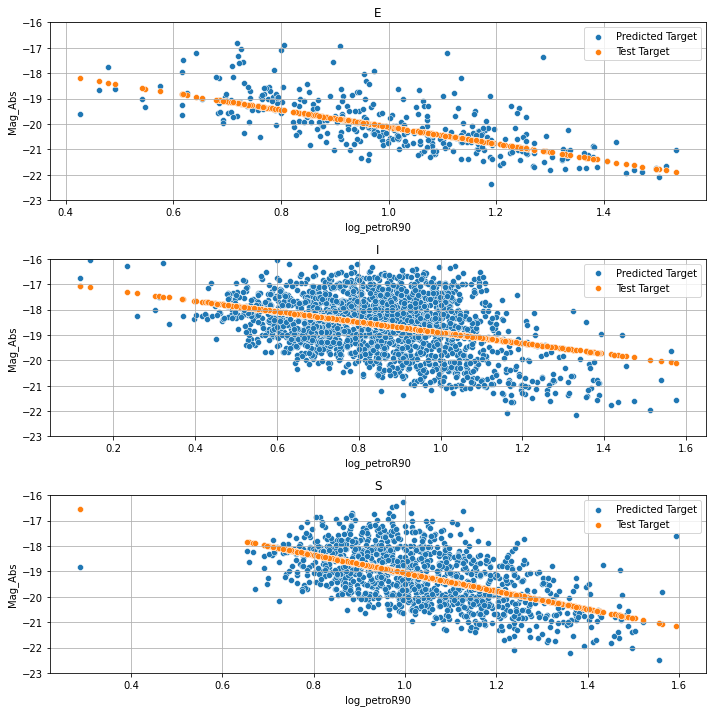

In [32]:
f, axs = plt.subplots(3,1, figsize=(10,10))
for idx, ttype in enumerate(data_cl["Type"].unique()):
    sns.scatterplot(y=y_test_d[ttype],      x=X_test_d[ttype].reshape(1,-1)[0], ax=axs[idx],
                   label="Predicted Target")
    sns.scatterplot(y=y_pred_test_d[ttype], x=X_test_d[ttype].reshape(1,-1)[0], ax=axs[idx], 
                    label="Test Target")
    
    axs[idx].set_xlabel("log_petroR90")
    axs[idx].set_ylabel("Mag_Abs")
    axs[idx].legend()
    axs[idx].grid()
    axs[idx].set_title(ttype)
    axs[idx].set_ylim([-23, -16])

plt.tight_layout()

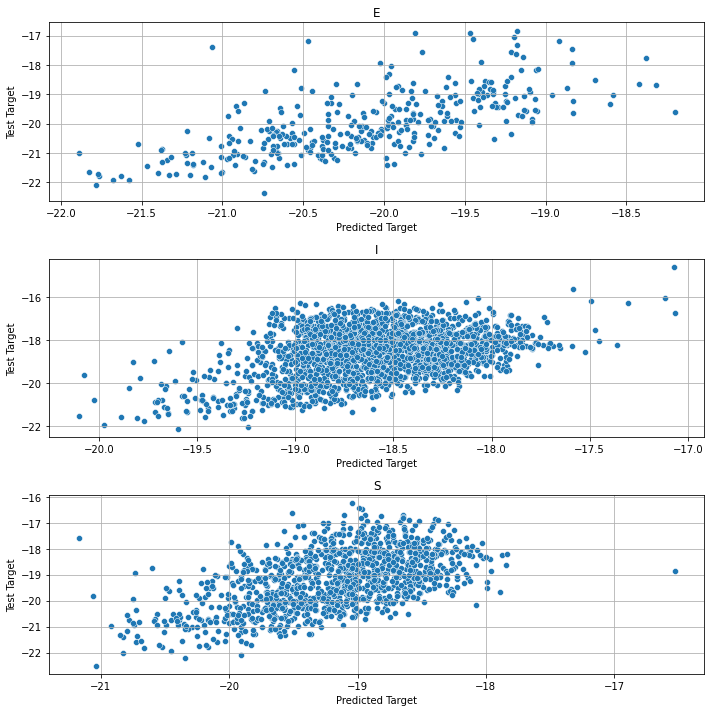

In [33]:
f, axs = plt.subplots(3,1, figsize=(10,10))
for idx, ttype in enumerate(data_cl["Type"].unique()):
    sns.scatterplot(x=y_pred_test_d[ttype], y=y_test_d[ttype], ax=axs[idx])
    axs[idx].grid()
    axs[idx].set_title(ttype)
    axs[idx].set_xlabel("Predicted Target")
    axs[idx].set_ylabel("Test Target")
plt.tight_layout()

## Respuestas

# Clasificación 

## Clasificación binaria 

Haga uso de los atributos petroR90_r, Color y Mag_abs para clasificar en  elípticas y espirales.

Use los siguientes modelos:

    - Perceptrón
    - Regresión logística
    - Vecinos más cercanos
    
Para cada uno de ellos muestre:

        - Matriz de confusión
        - Visualización de la frontera de decisión

In [34]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


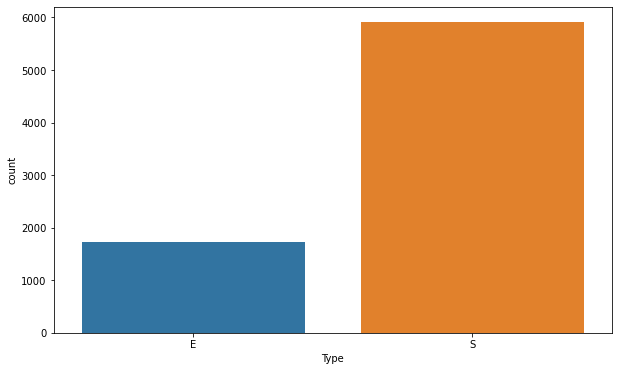

In [35]:
data_clf = data_cl[data_cl["Type"] != "I"]
sns.countplot(data_clf["Type"])

In [36]:
X_clf = data_clf[["petroR90_r", "Mag_abs", "Color"]]
y_clf = data_clf["Type"]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42421)
#X_train, X_test = X_train.values.reshape(-1,1), X_test.values.reshape(-1,1)

In [37]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std   = std.transform(X_test)

In [38]:
def print_classification_report(y_real, y_pred):
    print(f"Accuracy {accuracy_score(y_real, y_pred)}")
    print("-"*100)
    print(classification_report(y_real, y_pred))
    plt.figure()
    sns.heatmap(confusion_matrix(y_real, y_pred), 
                #xticklabels=x_ticks, #[0, 1],
                #yticklabels=x_ticks, #[0, 1],
                cmap="jet",
                annot=True,
               )
    plt.xlabel("Predicted Class")
    plt.ylabel("Real Class")
    plt.show()

In [39]:
perc    = Perceptron(random_state=421)
log_reg = LogisticRegression(random_state=421)
knn     = KNeighborsClassifier(n_neighbors=5)

### Hiper parametros por defecto

In [40]:
for model in [perc, log_reg, knn]:
    model.fit(X_train_std, y_train)

In [41]:
for model in [perc, log_reg, knn]:
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    print("="*80)
    print(model.__class__.__name__)
    print("="*80)
    print("Accuracy Train: ", accuracy_score(y_train, y_pred_train))
    print("F1 score Train: ", f1_score(y_train, y_pred_train, pos_label = 'S'))
    print("Accuracy Test: ", accuracy_score(y_test, y_pred_test))
    print("F1 score Test: ", f1_score(y_test, y_pred_test, pos_label = 'S'))

Perceptron
Accuracy Train:  0.5929319371727748
F1 score Train:  0.6925358378645575
Accuracy Test:  0.5925441465009811
F1 score Test:  0.6923456790123456
LogisticRegression
Accuracy Train:  0.8444044502617801
F1 score Train:  0.9014201306105524
Accuracy Test:  0.8404185742315239
F1 score Test:  0.8990066225165562
KNeighborsClassifier
Accuracy Train:  0.899705497382199
F1 score Train:  0.9355347565464297
Accuracy Test:  0.8449967298888162
F1 score Test:  0.9012088370154231


LogisticRegression
Train
--------------------------------------------------------------------------------
Accuracy 0.8444044502617801
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.69      0.58      0.63      1392
           S       0.88      0.92      0.90      4720

    accuracy                           0.84      6112
   macro avg       0.78      0.75      0.77      6112
weighted avg       0.84      0.84      0.84      6112



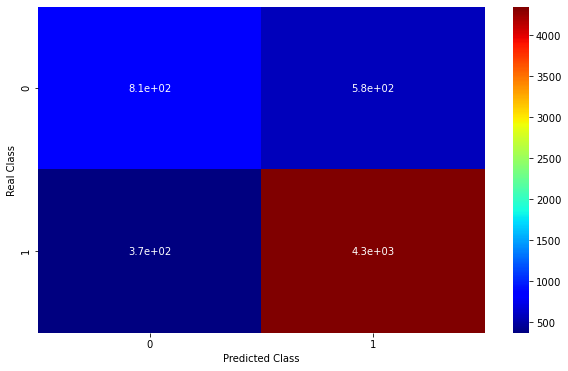

--------------------------------------------------------------------------------
Test
--------------------------------------------------------------------------------
Accuracy 0.8404185742315239
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.65      0.59      0.62       338
           S       0.89      0.91      0.90      1191

    accuracy                           0.84      1529
   macro avg       0.77      0.75      0.76      1529
weighted avg       0.84      0.84      0.84      1529



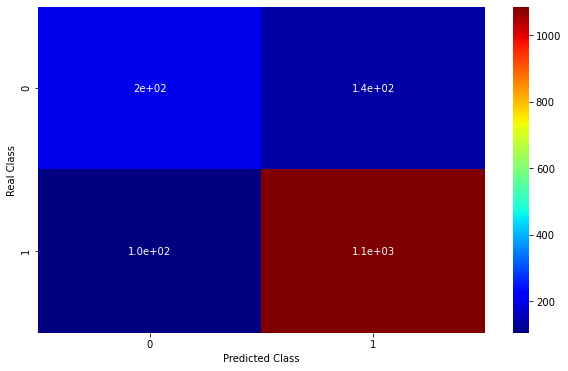

KNeighborsClassifier
Train
--------------------------------------------------------------------------------
Accuracy 0.899705497382199
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.79      0.76      0.77      1392
           S       0.93      0.94      0.94      4720

    accuracy                           0.90      6112
   macro avg       0.86      0.85      0.85      6112
weighted avg       0.90      0.90      0.90      6112



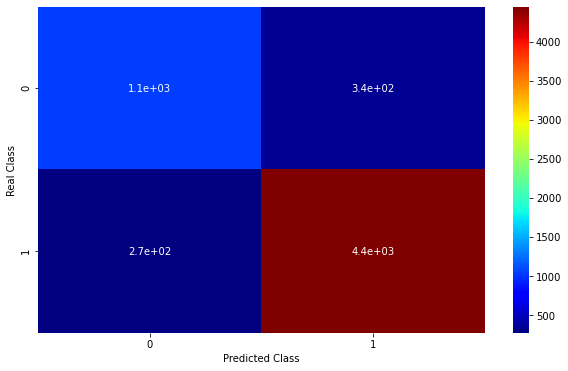

--------------------------------------------------------------------------------
Test
--------------------------------------------------------------------------------
Accuracy 0.8449967298888162
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.66      0.62      0.64       338
           S       0.89      0.91      0.90      1191

    accuracy                           0.84      1529
   macro avg       0.78      0.77      0.77      1529
weighted avg       0.84      0.84      0.84      1529



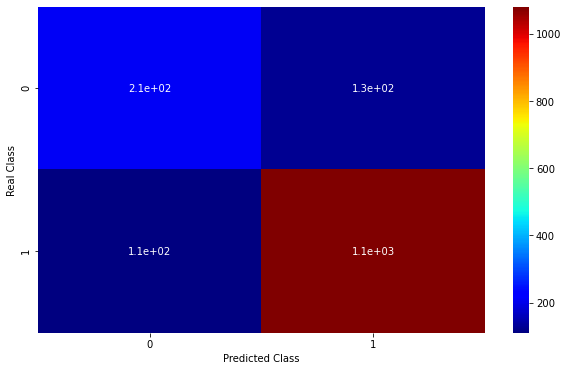

In [42]:
for model in [log_reg, knn]:
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    print("="*80)
    print(model.__class__.__name__)
    print("="*80)
    print("Train")
    print("-"*80)
    print_classification_report(y_train, y_pred_train)
    print("-"*80)
    print("Test")
    print("-"*80)
    print_classification_report(y_test, y_pred_test)

### Ajuste Hiper Parametros

Como no hay muchos hiperparametros vamos a usar validation curve

In [43]:
from sklearn.model_selection import validation_curve

In [44]:
x_logspace =  np.logspace(-6,1,7)
train_scores, valid_scores =  validation_curve(LogisticRegression(solver="lbfgs"),
                                               X_train_std, y_train, "C", x_logspace,
                                               cv=5)

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=C, param_range=[1.00000000e-06 1.46779927e-05 2.15443469e-04 3.16227766e-03
 4.64158883e-02 6.81292069e-01 1.00000000e+01] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


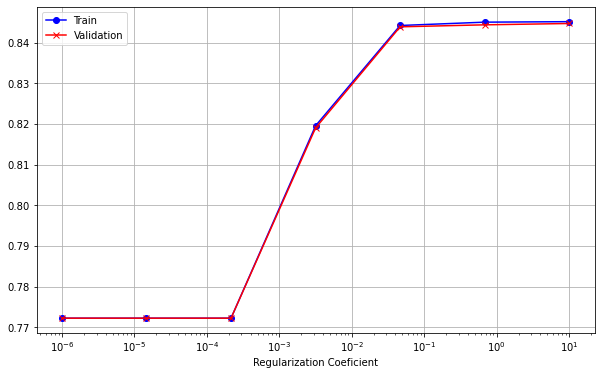

In [45]:
plt.semilogx(x_logspace, np.mean(train_scores,axis=1), "-ob", label="Train")
plt.semilogx(x_logspace, np.mean(valid_scores,axis=1), "-xr", label="Validation")
plt.grid()
plt.xlabel("Regularization Coeficient")
plt.legend(loc=0)

In [46]:
x_logspace =  range(1, 15)
train_scores, valid_scores =  validation_curve(KNeighborsClassifier(),
                                               X_train_std, y_train, "n_neighbors", x_logspace,
                                               cv=5, n_jobs=-1)

/home/vanessa/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=range(1, 15) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


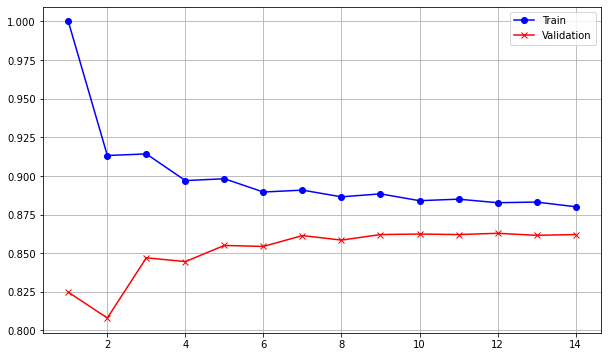

In [47]:
plt.plot(x_logspace, np.mean(train_scores,axis=1), "-ob", label="Train")
plt.plot(x_logspace, np.mean(valid_scores,axis=1), "-xr", label="Validation")
plt.grid()
plt.legend(loc=0)

Vemos que pasa con el test cuando usamos nneighbors = 9

KNeighborsClassifier
Train
--------------------------------------------------------------------------------
Accuracy 0.8895615183246073
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.77      0.74      0.75      1392
           S       0.92      0.93      0.93      4720

    accuracy                           0.89      6112
   macro avg       0.85      0.84      0.84      6112
weighted avg       0.89      0.89      0.89      6112



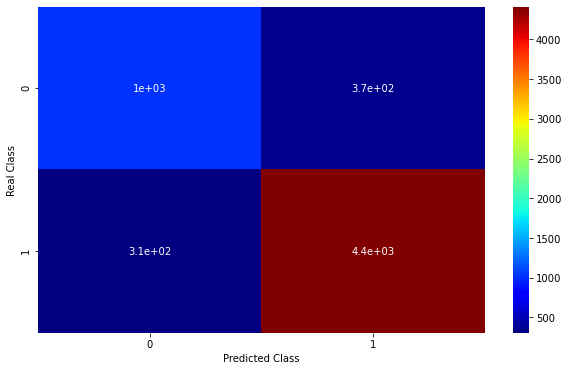

--------------------------------------------------------------------------------
Test
--------------------------------------------------------------------------------
Accuracy 0.854153041203401
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.67      0.67      0.67       338
           S       0.91      0.91      0.91      1191

    accuracy                           0.85      1529
   macro avg       0.79      0.79      0.79      1529
weighted avg       0.85      0.85      0.85      1529



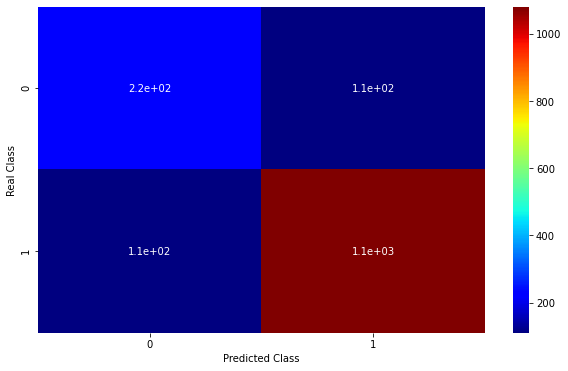

In [48]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_std, y_train)
y_pred_train = knn.predict(X_train_std)
y_pred_test = knn.predict(X_test_std)
print("="*80)
print(knn.__class__.__name__)
print("="*80)
print("Train")
print("-"*80)
print_classification_report(y_train, y_pred_train)
print("-"*80)
print("Test")
print("-"*80)
print_classification_report(y_test, y_pred_test)

### Curvas Precision/Recall y ROC

In [49]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder

y_scores = cross_val_predict(LogisticRegression(solver="lbfgs"),
                                               X_train_std, y_train ,cv=5,
                                               method="decision_function")


Text(0.5, 0, 'Threshold')

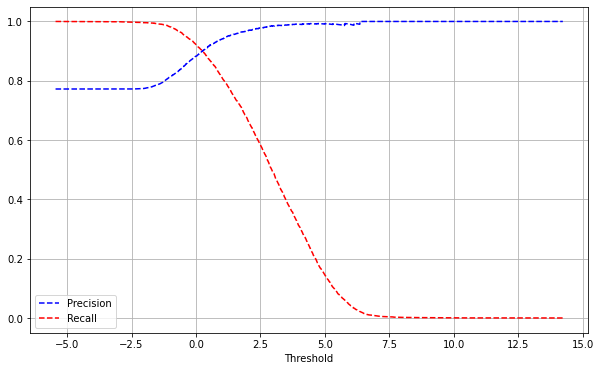

In [50]:
prec, rec, th = precision_recall_curve(LabelEncoder().fit_transform(y_train), y_scores)
plt.plot(th, prec[:-1], "--b", label="Precision")
plt.plot(th, rec[:-1], "--r", label="Recall")
plt.legend()
plt.grid()
plt.xlabel("Threshold")

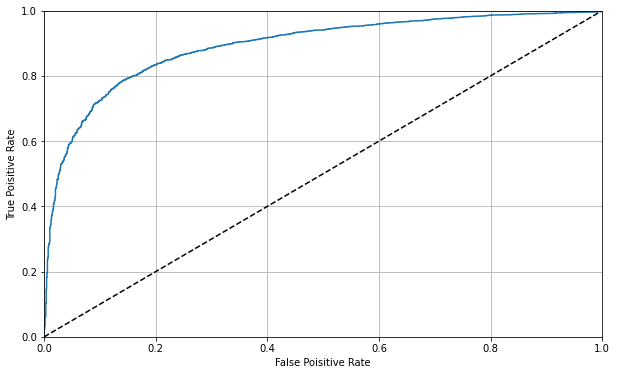

In [51]:
fpr, tpr, th = roc_curve(LabelEncoder().fit_transform(y_train), y_scores)

plt.plot(fpr, tpr, label="ROC Log Regr")
plt.plot([0,1],[0,1], "--k")
plt.axis([0,1,0,1])
plt.xlabel("False Poisitive Rate")
plt.ylabel("True Poisitive Rate")
plt.grid()


### Fronteras

In [52]:
from matplotlib.colors import ListedColormap
from ml.visualization import plot_confusion_matrix, classifier_boundary

## Clasificación multiclase
Haga uso de los atributos petroR90_r, Color y Mag_abs para clasificar en elípticas, espirales e irregulares.

Use los siguientes modelos:

    - SGDClassifier con y sin Ajuste de Hiperparámetros
    - Árbol de Decisión con y sin Ajuste de Hiperparámetros
    
Para cada uno de ellos muestre:

        - Accuracy
        - Precision
        - Recall
        - F1
        - matriz de confusión

        

Responda: 
- Que métrica es la más apropiadad a usar en este problema de clasificación?

In [53]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [54]:
data_clf = data_cl
X_clf = data_clf[["petroR90_r", "Mag_abs", "Color"]]
y_clf = data_clf["Type"]
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42421)

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std   = std.transform(X_test)

### Parámetros por defecto

In [55]:
sgd_clf    = SGDClassifier(random_state=421)
tree_clf = DecisionTreeClassifier(random_state=421)

In [56]:
for model in [sgd_clf,tree_clf]:
    model.fit(X_train_std, y_train)

In [57]:
for model in [sgd_clf,tree_clf]:
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    print("="*80)
    print(model.__class__.__name__)
    print("="*80)
    print("Accuracy Train: ", accuracy_score(y_train, y_pred_train))
    print("F1-score Train: ", f1_score(y_train, y_pred_train, average = 'weighted'))
    print("Accuracy Test: ", accuracy_score(y_test, y_pred_test))
    print("F1-score Test: ", f1_score(y_train, y_pred_train, average = 'weighted'))
    #print("Train")
    #print("-"*80)
    #print_classification_report(y_train, y_pred_train)
    #print("-"*80)
    #print("Test")
    #print("-"*80)
    #print_classification_report(y_test, y_pred_test)

SGDClassifier
Accuracy Train:  0.6416522040958
F1-score Train:  0.5818236933880218
Accuracy Test:  0.648528595224875
F1-score Test:  0.5818236933880218
DecisionTreeClassifier
Accuracy Train:  1.0
F1-score Train:  1.0
Accuracy Test:  0.5866185452526375
F1-score Test:  1.0


### Ajuste de Hiper Parametros

In [58]:
from sklearn.model_selection import GridSearchCV

#### SGD

In [59]:
param_grid = {
    "loss":['hinge', 'log', "perceptron"],
    "penalty": ["l1", "l2", None],
    "alpha": [1e-5, 1e-4, 1e-3],
    }
sgd_clf    = SGDClassifier(random_state=2402)
grid_sgd = GridSearchCV(sgd_clf, param_grid=param_grid, cv=5, scoring="accuracy")

In [60]:
grid_sgd.fit(X_train_std, y_train)
means = grid_sgd.cv_results_['mean_test_score']
stds = grid_sgd.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, grid_sgd.cv_results_['params']), 
                                key=lambda data: data[0], reverse=True):
    print("%0.4f (+/-%0.04f) para %r" % (mean, std * 2, params))

0.6559 (+/-0.0206) para {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}
0.6558 (+/-0.0204) para {'alpha': 0.0001, 'loss': 'log', 'penalty': None}
0.6554 (+/-0.0224) para {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}
0.6554 (+/-0.0145) para {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
0.6550 (+/-0.0091) para {'alpha': 0.001, 'loss': 'log', 'penalty': None}
0.6546 (+/-0.0089) para {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
0.6501 (+/-0.0058) para {'alpha': 1e-05, 'loss': 'log', 'penalty': 'l1'}
0.6488 (+/-0.0090) para {'alpha': 1e-05, 'loss': 'hinge', 'penalty': 'l2'}
0.6458 (+/-0.0090) para {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
0.6454 (+/-0.0095) para {'alpha': 0.0001, 'loss': 'hinge', 'penalty': None}
0.6443 (+/-0.0092) para {'alpha': 1e-05, 'loss': 'log', 'penalty': None}
0.6442 (+/-0.0090) para {'alpha': 1e-05, 'loss': 'log', 'penalty': 'l2'}
0.6436 (+/-0.0067) para {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l1'}
0.6434 (+/-0.0063) para {'alpha': 0.00

SGDClassifier
Train:  0.6517875737591114
Test:  0.6579677956690727
Train
--------------------------------------------------------------------------------
Accuracy 0.6517875737591114
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.49      0.12      0.19      1379
           I       0.67      0.89      0.76      8271
           S       0.62      0.39      0.48      4755

    accuracy                           0.65     14405
   macro avg       0.59      0.47      0.48     14405
weighted avg       0.63      0.65      0.61     14405



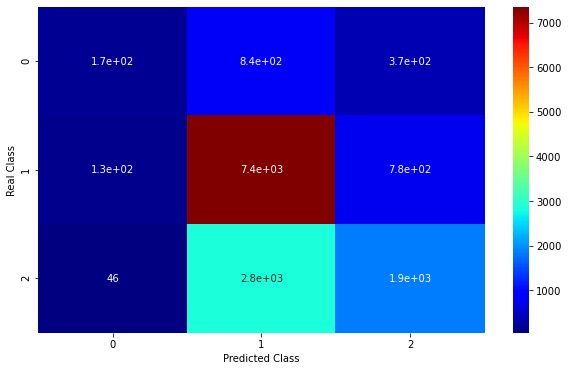

--------------------------------------------------------------------------------
Test
--------------------------------------------------------------------------------
Accuracy 0.6579677956690727
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.46      0.12      0.19       351
           I       0.68      0.90      0.77      2095
           S       0.62      0.39      0.48      1156

    accuracy                           0.66      3602
   macro avg       0.59      0.47      0.48      3602
weighted avg       0.64      0.66      0.62      3602



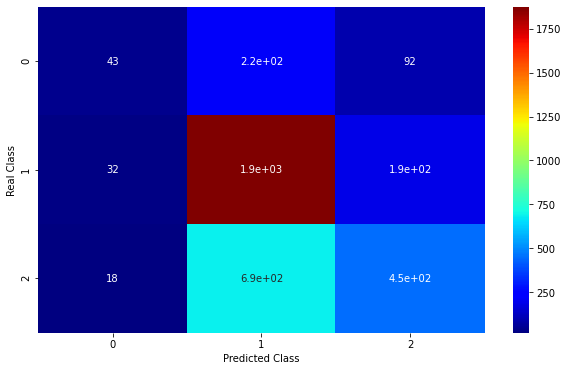

In [61]:
best_sgd = grid_sgd.best_estimator_
best_sgd.fit(X_train_std, y_train)

y_pred_train = best_sgd.predict(X_train_std)
y_pred_test = best_sgd.predict(X_test_std)
print("="*80)
print(best_sgd.__class__.__name__)
print("="*80)
print("Train: ", accuracy_score(y_train, y_pred_train))
print("Test: ", accuracy_score(y_test, y_pred_test))
print("Train")
print("-"*80)
print_classification_report(y_train, y_pred_train)
print("-"*80)
print("Test")
print("-"*80)
print_classification_report(y_test, y_pred_test)

#### Arbol de Decisión

In [62]:
param_grid = {
    "criterion":['gini', 'entropy'],
    "max_depth": [3, 4, 5, 7],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    }
tree_clf = DecisionTreeClassifier(random_state=421)
grid_tree = GridSearchCV(tree_clf, param_grid=param_grid, cv=5, scoring="accuracy")

In [63]:
grid_tree.fit(X_train_std, y_train)
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, grid_tree.cv_results_['params']), 
                                key=lambda data: data[0], reverse=True):
    print("%0.4f (+/-%0.04f) para %r" % (mean, std * 2, params))
print()

0.6753 (+/-0.0154) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}
0.6753 (+/-0.0154) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6}
0.6752 (+/-0.0156) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4}
0.6751 (+/-0.0158) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}
0.6750 (+/-0.0162) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
0.6750 (+/-0.0162) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}
0.6744 (+/-0.0200) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3}
0.6741 (+/-0.0221) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 6}
0.6739 (+/-0.0220) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}
0.6737 (+/-0.0212) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1}
0.6737 (+/-0.0211) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}
0.6733 (+/-0.0211) para {'criterion': 'entropy', '

DecisionTreeClassifier
Train:  0.6846928149947935
Test:  0.674069961132704
Train
--------------------------------------------------------------------------------
Accuracy 0.6846928149947935
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.51      0.29      0.37      1379
           I       0.70      0.86      0.77      8271
           S       0.67      0.49      0.57      4755

    accuracy                           0.68     14405
   macro avg       0.63      0.55      0.57     14405
weighted avg       0.67      0.68      0.67     14405



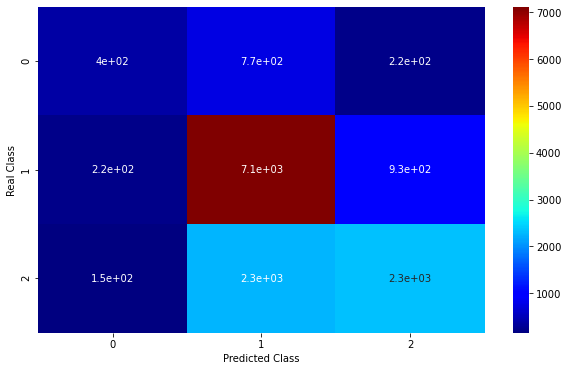

--------------------------------------------------------------------------------
Test
--------------------------------------------------------------------------------
Accuracy 0.674069961132704
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.48      0.27      0.34       351
           I       0.70      0.85      0.77      2095
           S       0.64      0.48      0.55      1156

    accuracy                           0.67      3602
   macro avg       0.61      0.53      0.55      3602
weighted avg       0.66      0.67      0.66      3602



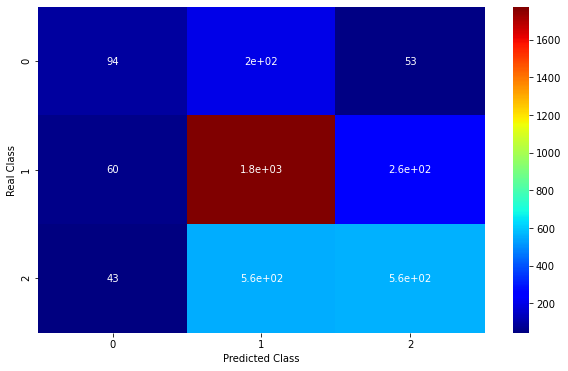

In [64]:
best_tree = grid_tree.best_estimator_
best_tree.fit(X_train_std, y_train)

y_pred_train = best_tree.predict(X_train_std)
y_pred_test = best_tree.predict(X_test_std)
print("="*80)
print(model.__class__.__name__)
print("="*80)
print("Train: ", accuracy_score(y_train, y_pred_train))
print("Test: ", accuracy_score(y_test, y_pred_test))
print("Train")
print("-"*80)
print_classification_report(y_train, y_pred_train)
print("-"*80)
print("Test")
print("-"*80)
print_classification_report(y_test, y_pred_test)

### Otras métricas

La matriz de confusión tiene la forma<br/>

| X | Positives | Negatives |
| --- | --- | --- |
| **Positives** | True Positives  | False Positives |
| **Negatives** | False Negatives | True Negatives  |

Una metrica que nos dice el accuracy que tenemos sobre los valores verdaderos es **precision**. Nos dice cuantos de los valores que detectamos como verdaderos realmente lo son:

$precision = \frac{TP}{TP+FP}$

Otra metrica interesante es **recall**. Nos dice que tan bueno fue el algoritmo para detectar bien a los positivos.

$recall = \frac{TP}{TP+FN}$

El **F1 score** es un promedio armonico de los 2 anteriores y solamnete va a tener un valor alto cuando los otros 2 sean altos

$F1 = 2 \times \frac{precision \times recall}{precision + recall}$

Utilizamos F1 como score porque las clases se encuentran desbalanceadas en este caso y ademas no tenemos especial interes en ninguna clase.

##### Score: f1-score

In [65]:
param_grid = {
    "criterion":['gini', 'entropy'],
    "max_depth": [3, 4, 5, 7],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    }
tree_clf = DecisionTreeClassifier(random_state=421)
grid_tree = GridSearchCV(tree_clf, param_grid=param_grid, cv=5, scoring="f1_weighted")
grid_tree.fit(X_train_std, y_train)
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, grid_tree.cv_results_['params']), 
                                key=lambda data: data[0], reverse=True):
    print("%0.4f (+/-%0.04f) para %r" % (mean, std * 2, params))

0.6612 (+/-0.0109) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}
0.6612 (+/-0.0109) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6}
0.6612 (+/-0.0110) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4}
0.6611 (+/-0.0109) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}
0.6610 (+/-0.0117) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
0.6610 (+/-0.0117) para {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}
0.6607 (+/-0.0204) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3}
0.6607 (+/-0.0224) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 6}
0.6605 (+/-0.0222) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}
0.6603 (+/-0.0217) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1}
0.6602 (+/-0.0208) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}
0.6598 (+/-0.0212) para {'criterion': 'entropy', '

DecisionTreeClassifier
Train:  0.6846928149947935
Test:  0.674069961132704
Train
--------------------------------------------------------------------------------
Accuracy 0.6846928149947935
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.51      0.29      0.37      1379
           I       0.70      0.86      0.77      8271
           S       0.67      0.49      0.57      4755

    accuracy                           0.68     14405
   macro avg       0.63      0.55      0.57     14405
weighted avg       0.67      0.68      0.67     14405



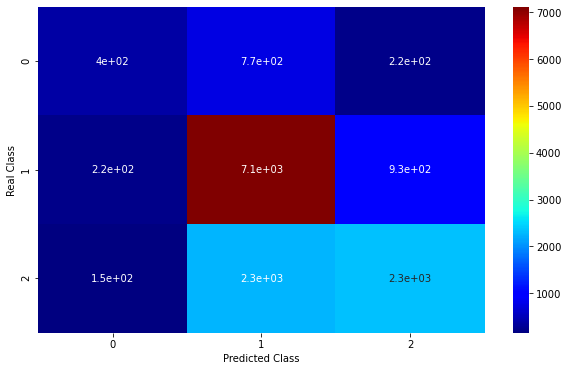

--------------------------------------------------------------------------------
Test
--------------------------------------------------------------------------------
Accuracy 0.674069961132704
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           E       0.48      0.27      0.34       351
           I       0.70      0.85      0.77      2095
           S       0.64      0.48      0.55      1156

    accuracy                           0.67      3602
   macro avg       0.61      0.53      0.55      3602
weighted avg       0.66      0.67      0.66      3602



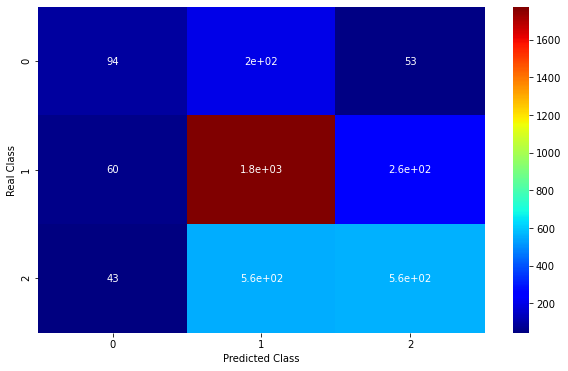

In [66]:
best_tree = grid_tree.best_estimator_
best_tree.fit(X_train_std, y_train)

y_pred_train = best_tree.predict(X_train_std)
y_pred_test = best_tree.predict(X_test_std)
print("="*80)
print(best_tree.__class__.__name__)
print("="*80)
print("Train: ", accuracy_score(y_train, y_pred_train))
print("Test: ", accuracy_score(y_test, y_pred_test))
print("Train")
print("-"*80)
print_classification_report(y_train, y_pred_train)
print("-"*80)
print("Test")
print("-"*80)
print_classification_report(y_test, y_pred_test)

## Veamos ahora que sucede al balancear las clases

In [67]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_colwidth', -1)

In [68]:
# NOTE: to the selected model we must be able to apply the fit method. Either way we can't use this function.

def cv_and_smote(clf, x_train, y_train, x_test, rnd = 22):
    warnings.filterwarnings('ignore')
    
    x_train_df = pd.DataFrame(x_train) 
    y_train_df = pd.DataFrame(y_train)
    
    kf = StratifiedKFold(n_splits=5, random_state=rnd)

    # lists to append scores
    cross_val_f1_score_lst = []
    cross_val_accuracy_lst = []
    cross_val_recall_lst = []
    cross_val_precision_lst = []

    for train_index_ls, validation_index_ls in kf.split(x_train, y_train):
    
        # splitting on train/validation    
        train, validation = x_train_df.iloc[train_index_ls], x_train_df.iloc[validation_index_ls]
        target_train, target_val = y_train_df.iloc[train_index_ls], y_train_df.iloc[validation_index_ls]
    
        sm = SMOTE(random_state=rnd)
    
        X_train_res, y_train_res = sm.fit_sample(train, target_train)
    
        # model definition
        clf.fit(X_train_res, y_train_res)
        
        # testing on 1 fold of validation set
        validation_pred = clf.predict(validation)
    
        # appending scores of differnet metrics
        cross_val_recall_lst.append(recall_score(target_val, validation_pred, average = 'macro'))
        cross_val_accuracy_lst.append(accuracy_score(target_val, validation_pred))
        cross_val_precision_lst.append(precision_score(target_val, validation_pred, average = 'macro'))
        cross_val_f1_score_lst.append(f1_score(target_val, validation_pred, average = 'macro'))
           
    y_pred_test = clf.predict(x_test) 
    
    return (np.mean(cross_val_accuracy_lst), 
            np.mean(cross_val_recall_lst), 
            np.mean(cross_val_precision_lst), 
            np.mean(cross_val_f1_score_lst), 
            y_pred_test)


# Imágenes

Por ultimo, 
- Armen un conjunto de 100 imágenes [300, 300, 5] (guarden ese conjunto de datos. img.formato)
- Elijan el modelo con la mejor performance y apliquen sobre el conjunto de imágenes. 

- Dejen un análisis de las performas que obtiene con ese modelo tanto para imágenes como para valores de tabla. 
- Está bn realizar este procedimiento en este tipo de problema?. Es decir, tomar un modelo que clasifica bien a el mismo conjunto de galaxias usando datos de tabla

## Conclusión